In [1]:
from vivarium import Artifact
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from db_queries import get_ids, get_outputs
import scipy.stats
from get_draws.api import get_draws

In [2]:
output_dirs = ['/share/costeffectiveness/results/vivarium_conic_lsff/ethiopia/2020_06_28_12_40_56/count_data/',
               '/share/costeffectiveness/results/vivarium_conic_lsff/india/2020_06_26_20_35_00/count_data/',
              '/share/costeffectiveness/results/vivarium_conic_lsff/nigeria/2020_06_26_20_28_27/count_data/']

locations = ['Ethiopia','India','Nigeria']

# Validate anemia prevalence using anemia impairment prevalence from GBD

In [3]:
# get simulation anemia prevalence

anemia_prev = pd.DataFrame()
for i in range(len(output_dirs)):
    anemia_pt = pd.read_hdf(output_dirs[i] + 'anemia_state_person_time.hdf')
    anemia_pt = anemia_pt.groupby(['input_draw','age_group','scenario','measure']).sum()
    pt = pd.read_hdf(output_dirs[i] + 'state_person_time.hdf')
    pt = pt.loc[pt.cause.str.contains('diarrheal')]
    pt = pt.groupby(['input_draw','age_group','scenario']).sum()
    prev = anemia_pt / pt
    prev = prev.reset_index()
    prev['location'] = locations[i]
    anemia_prev = anemia_prev.append(prev)
anemia_prev = anemia_prev.rename(columns={'measure':'severity'})
anemia_prev['measure'] = 'prevalence'
anemia_prev = anemia_prev.set_index(['location','age_group','input_draw','severity','scenario','value','measure']).reset_index()
anemia_prev.head()

,location,age_group,input_draw,severity,scenario,value,measure
0,Ethiopia,1_to_4,21,anemia_mild,baseline,0.268626,prevalence
1,Ethiopia,1_to_4,21,anemia_moderate,baseline,0.323264,prevalence
2,Ethiopia,1_to_4,21,anemia_none,baseline,0.386224,prevalence
3,Ethiopia,1_to_4,21,anemia_severe,baseline,0.021886,prevalence
4,Ethiopia,1_to_4,21,anemia_mild,folic_acid_fortification_scale_up,0.268626,prevalence


In [4]:
# get simulation anemia YLD rate

anemia_ylds = pd.DataFrame()
for i in range(len(output_dirs)):
    ylds = pd.read_hdf(output_dirs[i] + 'ylds.hdf')
    ylds_anemia = ylds.loc[ylds.cause == 'iron_deficiency']
    ylds_anemia = ylds_anemia.groupby(['input_draw','age_group','scenario']).sum()
    pt = pd.read_hdf(output_dirs[i] + 'state_person_time.hdf')
    pt = pt.loc[pt.cause.str.contains('diarrheal')]
    pt = pt.groupby(['input_draw','age_group','scenario']).sum()
    anemia_yld_rate = ylds_anemia / pt
    anemia_yld_rate = anemia_yld_rate.reset_index()
    anemia_yld_rate['location'] = locations[i]
    anemia_ylds = anemia_ylds.append(anemia_yld_rate)
anemia_ylds['measure'] = 'ylds'
anemia_ylds['severity'] = 'anemia_total'
anemia_ylds = anemia_ylds.set_index(['location','age_group','input_draw','severity','scenario','value','measure']).reset_index()
anemia_ylds.head()

,location,age_group,input_draw,severity,scenario,value,measure
0,Ethiopia,1_to_4,21,anemia_total,baseline,0.024155,ylds
1,Ethiopia,1_to_4,21,anemia_total,folic_acid_fortification_scale_up,0.024155,ylds
2,Ethiopia,1_to_4,21,anemia_total,iron_folic_acid_fortification_scale_up,0.023941,ylds
3,Ethiopia,1_to_4,21,anemia_total,vitamin_a_fortification_scale_up,0.024155,ylds
4,Ethiopia,early_neonatal,21,anemia_total,baseline,0.060684,ylds


In [5]:
# combine model prevalence and ylds

anemia_model = anemia_prev.append(anemia_ylds)
anemia_model = anemia_model.loc[anemia_model.scenario == 'baseline']
anemia_model = anemia_model.sort_values(by=['location','measure','severity','age_group'])
anemia_model.head()

,location,age_group,input_draw,severity,scenario,value,measure
0,Ethiopia,1_to_4,21,anemia_mild,baseline,0.268626,prevalence
64,Ethiopia,1_to_4,29,anemia_mild,baseline,0.272499,prevalence
128,Ethiopia,1_to_4,55,anemia_mild,baseline,0.271476,prevalence
192,Ethiopia,1_to_4,78,anemia_mild,baseline,0.270541,prevalence
256,Ethiopia,1_to_4,155,anemia_mild,baseline,0.270468,prevalence


In [6]:
anemia_model_mean = anemia_model.groupby(['age_group','location','measure','severity']).mean().reset_index()
anemia_model_mean.head()

,age_group,location,measure,severity,input_draw,value
0,1_to_4,Ethiopia,prevalence,anemia_mild,437.52,0.269762
1,1_to_4,Ethiopia,prevalence,anemia_moderate,437.52,0.314004
2,1_to_4,Ethiopia,prevalence,anemia_none,437.52,0.396146
3,1_to_4,Ethiopia,prevalence,anemia_severe,437.52,0.020089
4,1_to_4,Ethiopia,ylds,anemia_total,437.52,0.021500


In [7]:
# get global anemia impairment prevalence and YLD rate from GBD

gbd_anemia = get_draws('rei_id', [192,205,206,207], source='como', measure_id=[3,5], location_id=[179,163,214], 
                   year_id=2017, gbd_round_id=5, age_group_id=[2,3,4,5])
gbd_anemia = gbd_anemia.loc[gbd_anemia.cause_id == 294]
gbd_anemia = gbd_anemia.set_index(['age_group_id','location_id', 'measure_id', 'rei_id',
                                 'sex_id', 'year_id', 'metric_id','cause_id'])



In [8]:
# get means and LCLs, UCLs
gbd = (gbd_anemia.apply(pd.DataFrame.describe, percentiles=[0.025,0.975], axis=1)
       .drop(columns=['count','std','min','max','50%'])
       .rename(columns={'2.5%':'lower','97.5%':'upper'}).reset_index())

# rename variables for compatibility
gbd['age_group'] = 0
gbd['age_group'] = np.where(gbd['age_group_id'] == 2, 'early_neonatal', 
                           np.where(gbd['age_group_id'] == 3, 'late_neonatal',
                                    np.where(gbd['age_group_id'] == 4, 'post_neonatal', 
                                            '1_to_4')))
gbd['sex'] = np.where(gbd['sex_id'] == 1, 'male', 'female')
gbd['anemia_group'] = np.where(gbd['rei_id'] == 205, 'anemia_mild', 
                               np.where(gbd['rei_id'] == 206, 'anemia_moderate',
                                        np.where(gbd['rei_id'] == 207, 'anemia_severe', 'anemia_total')))
gbd['location'] = np.where(gbd['location_id'] == 163, 'India',
                          np.where(gbd['location_id'] == 214, 'Nigeria', 'Ethiopia'))
gbd['measure'] = np.where(gbd['measure_id'] == 3, 'ylds', 'prevalence')
gbd = gbd.rename(columns={'anemia_group':'severity'})
gbd = gbd.drop(columns=['age_group_id','location_id','rei_id','sex_id','measure_id','metric_id'])
gbd.head()

,year_id,cause_id,mean,lower,upper,age_group,sex,severity,location,measure
0,2017,294,0.026172,0.016666,0.039066,early_neonatal,male,anemia_total,India,ylds
1,2017,294,0.001010,0.000358,0.002242,early_neonatal,male,anemia_mild,India,ylds
2,2017,294,0.020791,0.013063,0.031267,early_neonatal,male,anemia_moderate,India,ylds
3,2017,294,0.004371,0.002666,0.006530,early_neonatal,male,anemia_severe,India,ylds
4,2017,294,0.026141,0.016349,0.038769,late_neonatal,male,anemia_total,India,ylds


In [9]:
gbd = gbd.groupby(['age_group','severity','location','measure']).mean().drop(columns=['year_id','cause_id']).reset_index()
gbd.head()

,age_group,severity,location,measure,mean,lower,upper
0,1_to_4,anemia_mild,Ethiopia,prevalence,0.252188,0.228839,0.277322
1,1_to_4,anemia_mild,Ethiopia,ylds,0.000995,0.000403,0.002156
2,1_to_4,anemia_mild,India,prevalence,0.273359,0.255842,0.293852
3,1_to_4,anemia_mild,India,ylds,0.001057,0.000411,0.002339
4,1_to_4,anemia_mild,Nigeria,prevalence,0.243879,0.203368,0.279475


In [10]:
anemia_gbd = gbd.sort_values(by=['location','measure','severity','age_group'])
anemia_gbd.head()

,age_group,severity,location,measure,mean,lower,upper
0,1_to_4,anemia_mild,Ethiopia,prevalence,0.252188,0.228839,0.277322
24,early_neonatal,anemia_mild,Ethiopia,prevalence,0.256193,0.194615,0.303045
48,late_neonatal,anemia_mild,Ethiopia,prevalence,0.256185,0.195346,0.302203
72,post_neonatal,anemia_mild,Ethiopia,prevalence,0.255555,0.214019,0.293354
6,1_to_4,anemia_moderate,Ethiopia,prevalence,0.310836,0.274348,0.349281


In [11]:
for data_set in [anemia_model, anemia_model_mean, anemia_gbd]:
    data_set['age_group_order'] = np.where(data_set['age_group'] == 'early_neonatal', 1,
                                          np.where(data_set['age_group'] == 'late_neonatal', 2,
                                                  np.where(data_set['age_group'] == 'post_neonatal', 3,
                                                          np.where(data_set['age_group'] == '1_to_4', 4, 0))))
    
anemia_model = anemia_model.set_index(['location','severity','age_group_order']).sort_index().reset_index()
anemia_model_mean = anemia_model_mean.set_index(['location','severity','age_group_order']).sort_index().reset_index()
anemia_gbd = anemia_gbd.set_index(['location','severity','age_group_order']).sort_index().reset_index()

In [12]:
severity_list = ['anemia_mild','anemia_moderate','anemia_severe','anemia_total']

def make_multiple_plots(severity_list):
    for severity in severity_list:
        if severity == 'anemia_total':
            plot_measures = ['ylds']
        else:
            plot_measures = ['prevalence']
        for measure in plot_measures:
            for location in locations:
            
                measure_s = anemia_model.loc[anemia_model.severity == severity]
                measure_s = measure_s.loc[measure_s.measure == measure]
                measure_s = measure_s.loc[measure_s.location == location]

                measure_mean = anemia_model_mean.loc[anemia_model_mean.severity == severity]
                measure_m = measure_mean.loc[measure_mean.measure == measure]
                measure_m = measure_m.loc[measure_m.location == location]

                measure_gbd = anemia_gbd.loc[anemia_gbd.severity == severity]
                measure_g = measure_gbd.loc[measure_gbd.measure == measure]
                measure_g = measure_g.loc[measure_g.location == location]


                fig, ax = plt.subplots(figsize=(20, 10))
                clrs = sns.color_palette('husl', 1)

                g1 = sns.catplot(x='age_group', y='value', ax=ax, data=measure_s, 
                                 palette=clrs)

                sns.lineplot(x='age_group', y='mean', palette=clrs, 
                             linewidth=2, ax=ax, data=measure_g, sort=False)

            
                ax.fill_between(measure_g.age_group.values, measure_g.upper, measure_g.lower, alpha=0.3, 
                                label='GBD 95% CI', facecolor=clrs)
                ax.scatter(measure_m.age_group, measure_m.value, s=250, marker='P', 
                           label=f'Sim mean', c=clrs)

                ax.set_title(f'{location.capitalize()}, {measure} due to {severity}', fontsize=20)
                ax.set_xlabel('Age group', fontsize=18)

                l = ax.legend(loc=(1.02, 0.05), fontsize=12)
                labels = ['Sim mean']
                for text, label in zip(l.texts[1:5], labels):
                    text.set_text(label)

                plt.close(g1.fig)
                plt.savefig(f'{location}_{measure}_{severity}')

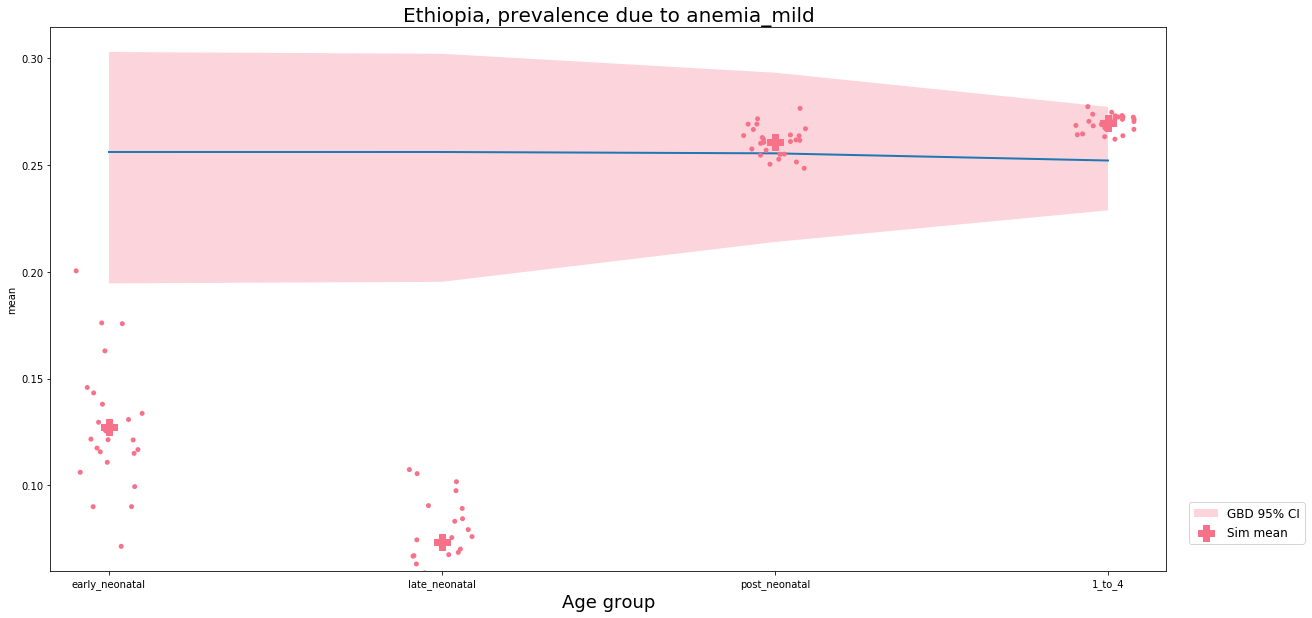

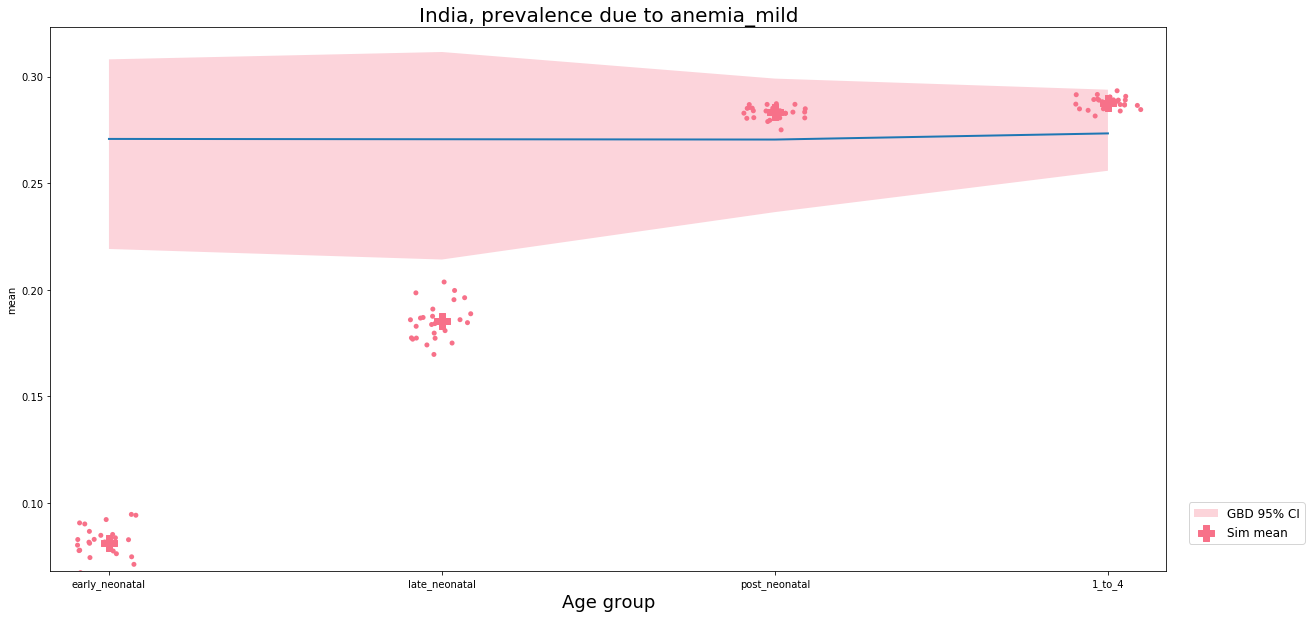

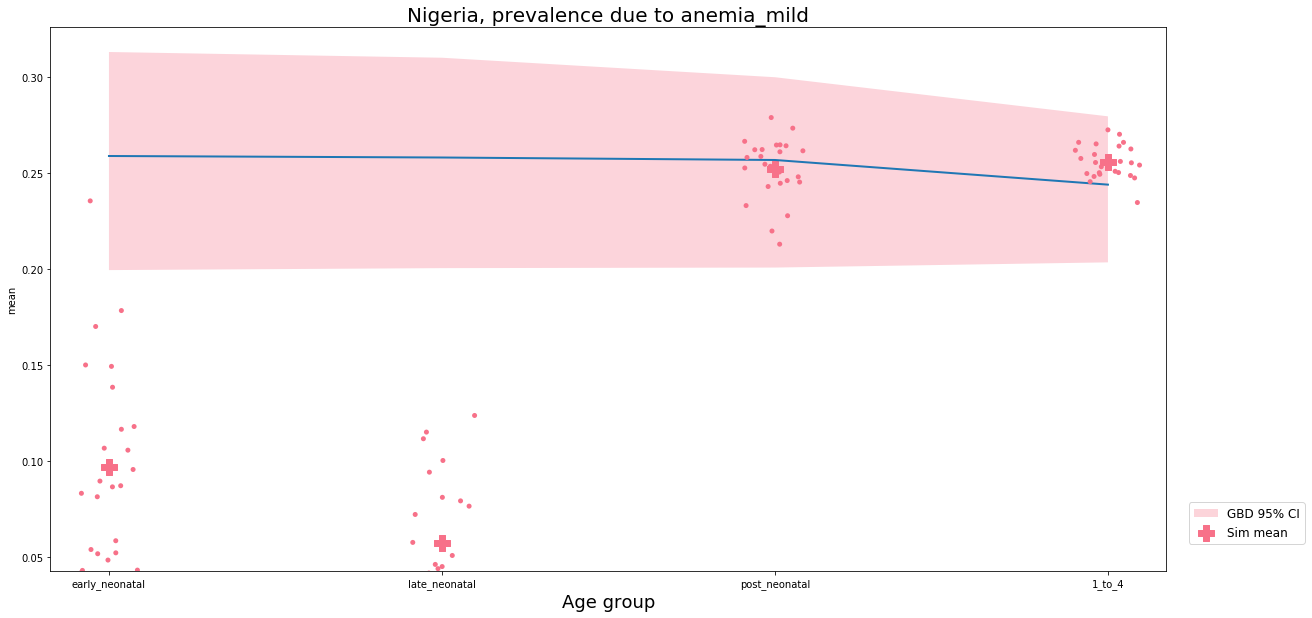

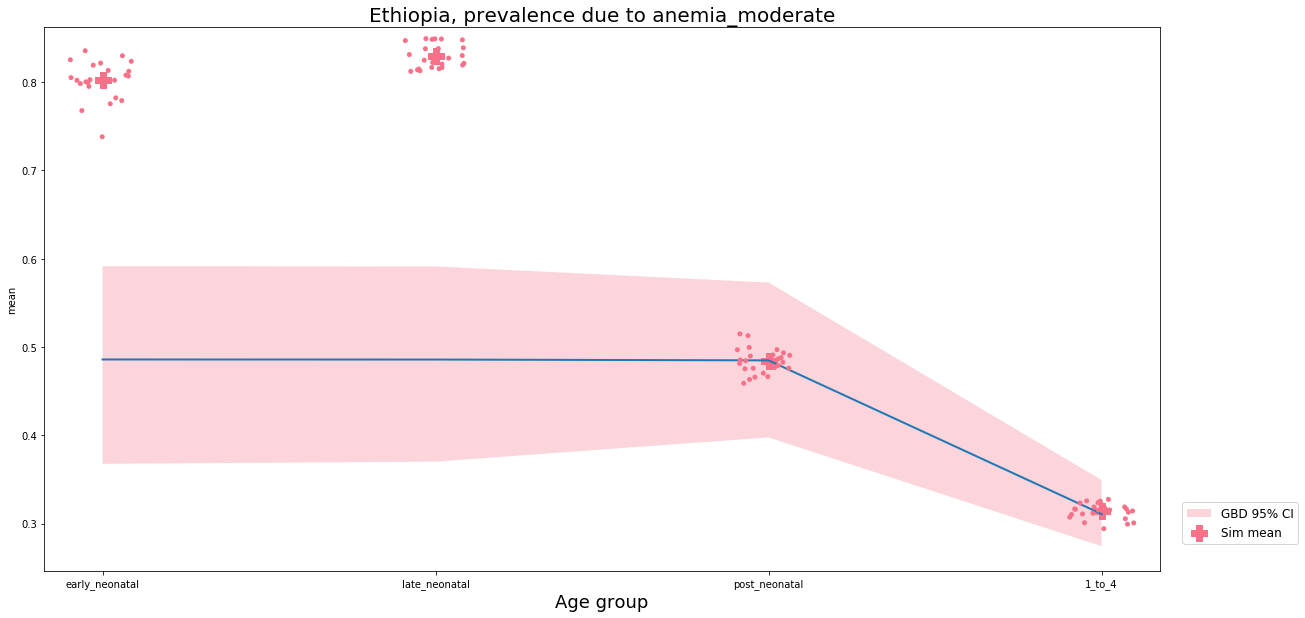

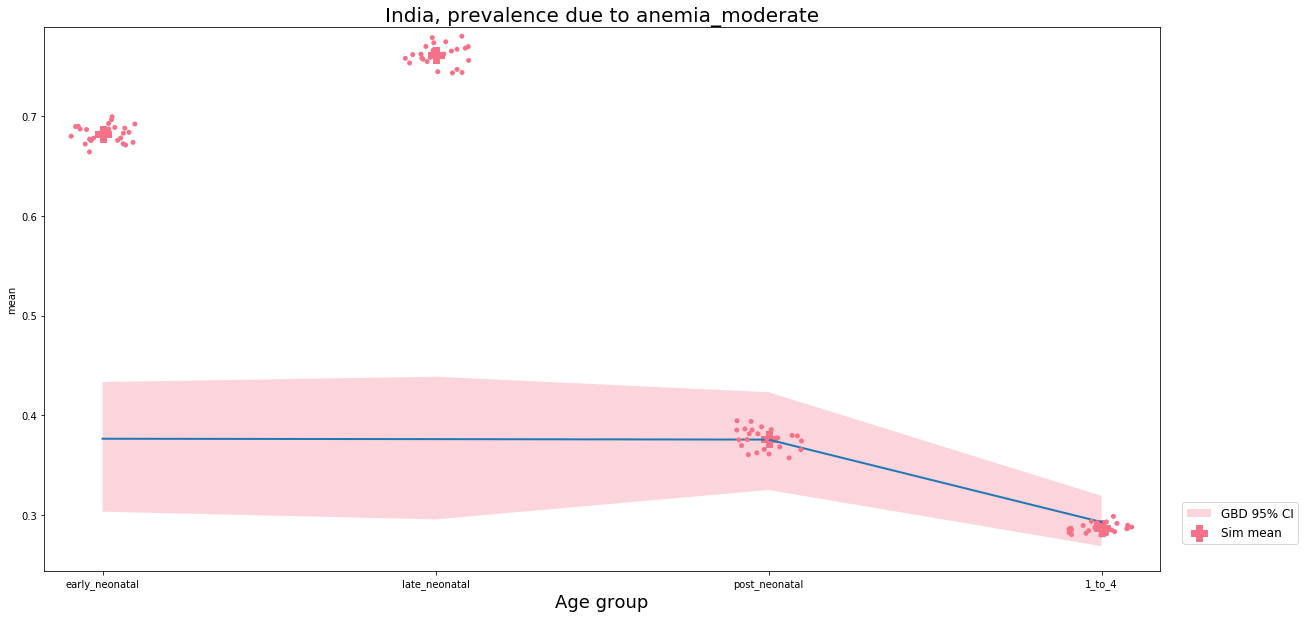

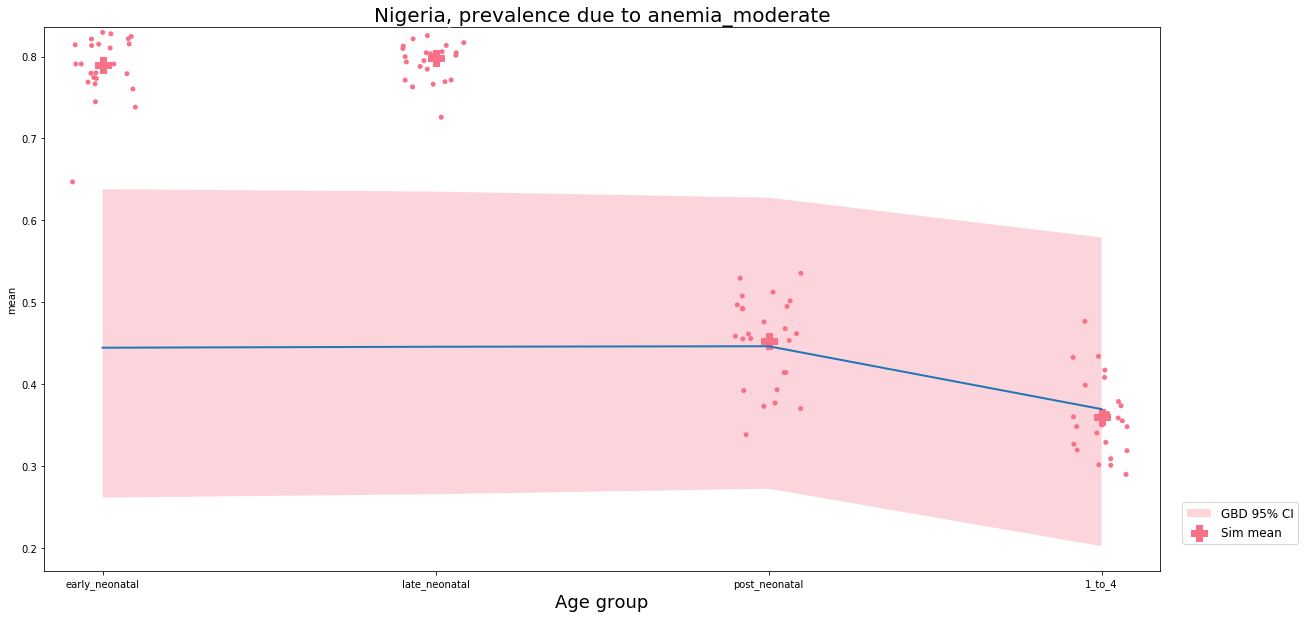

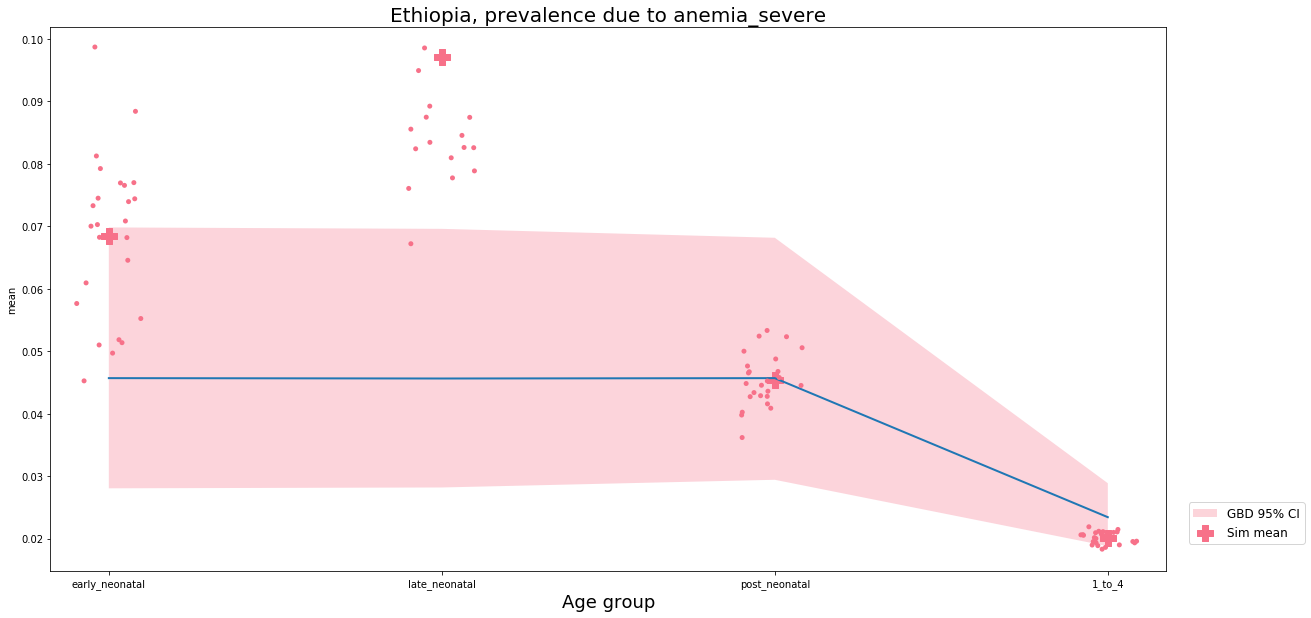

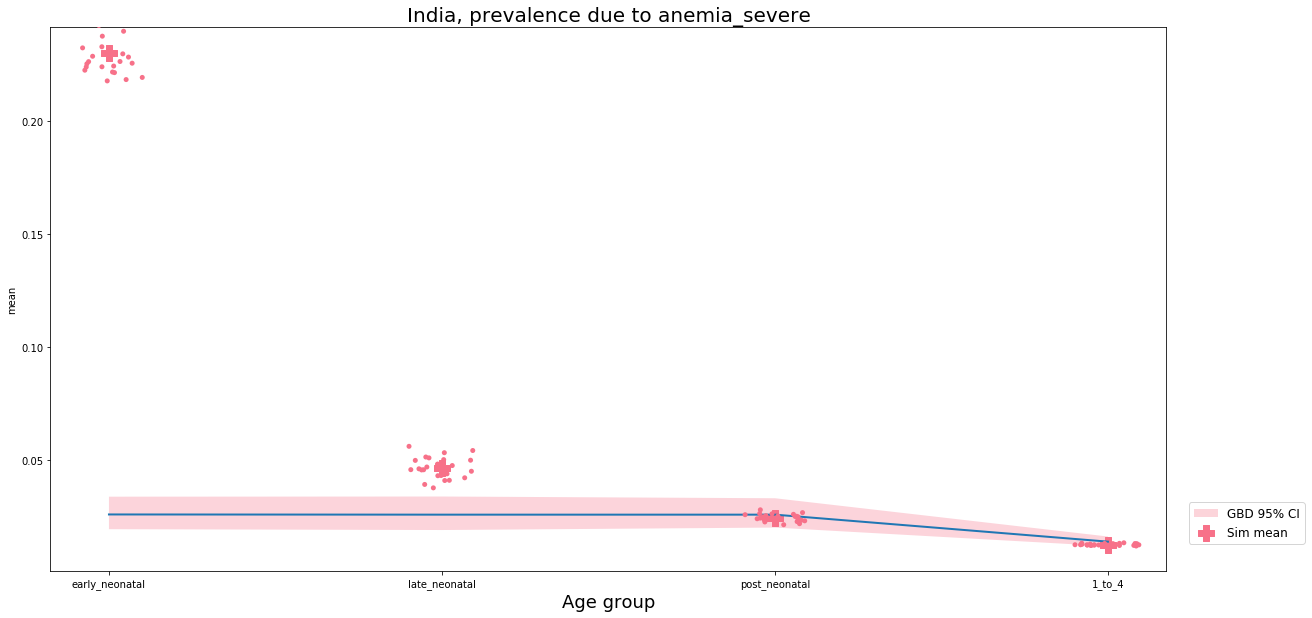

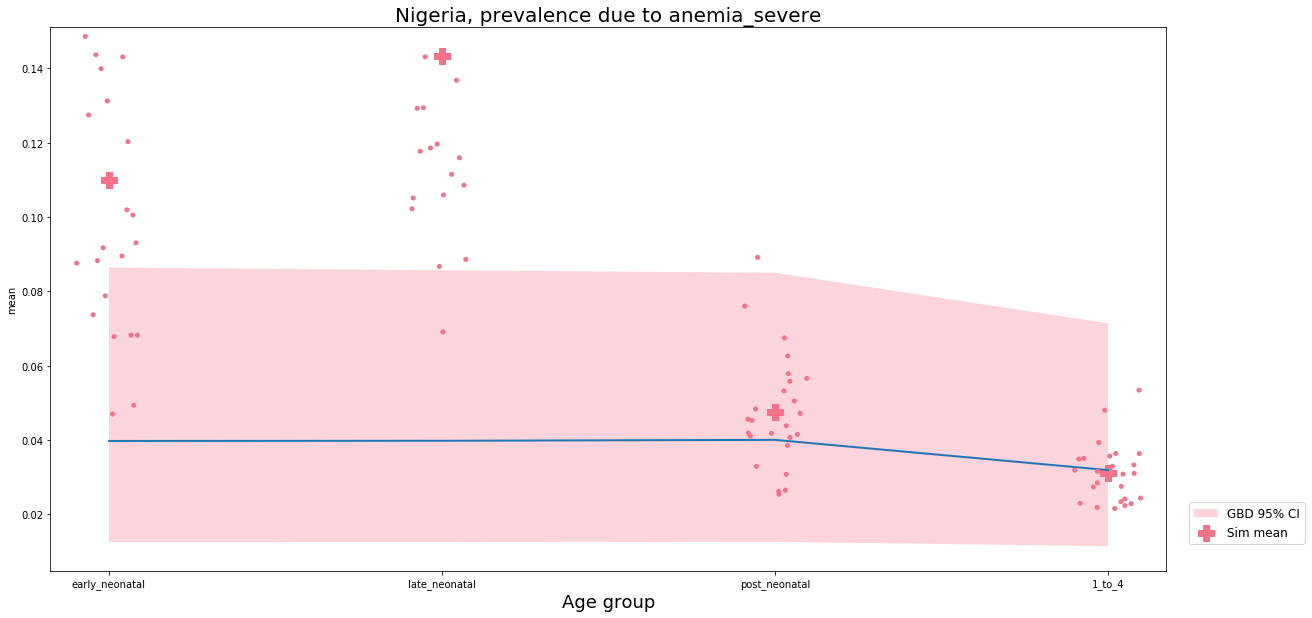

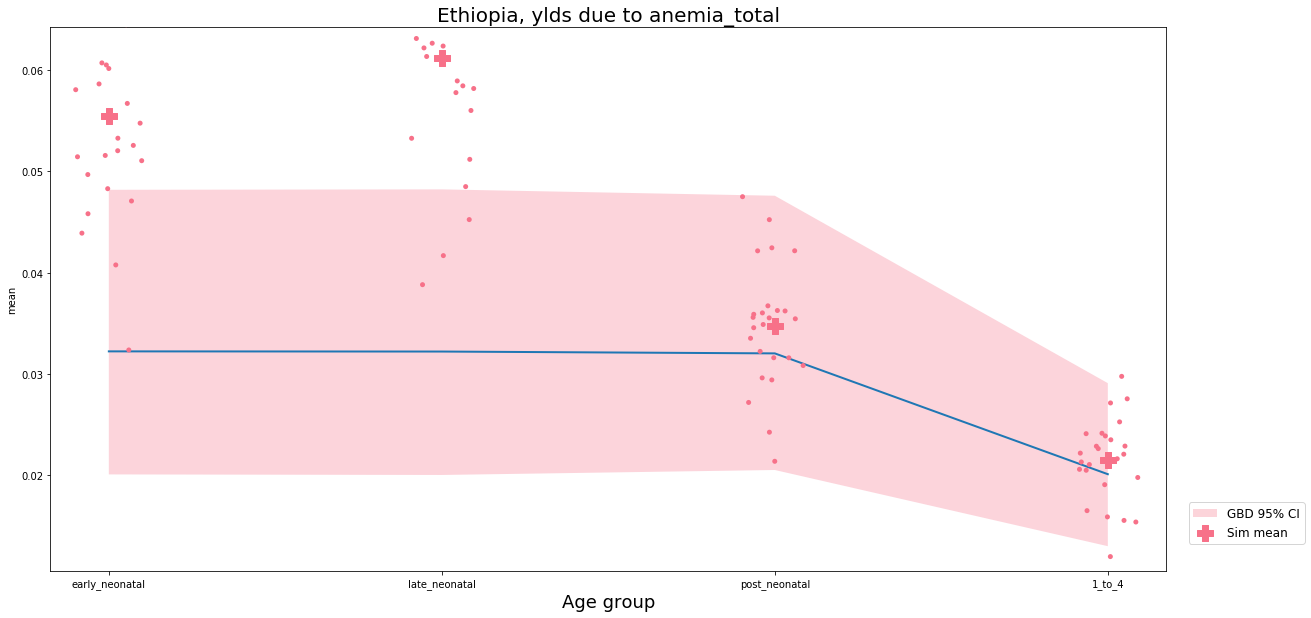

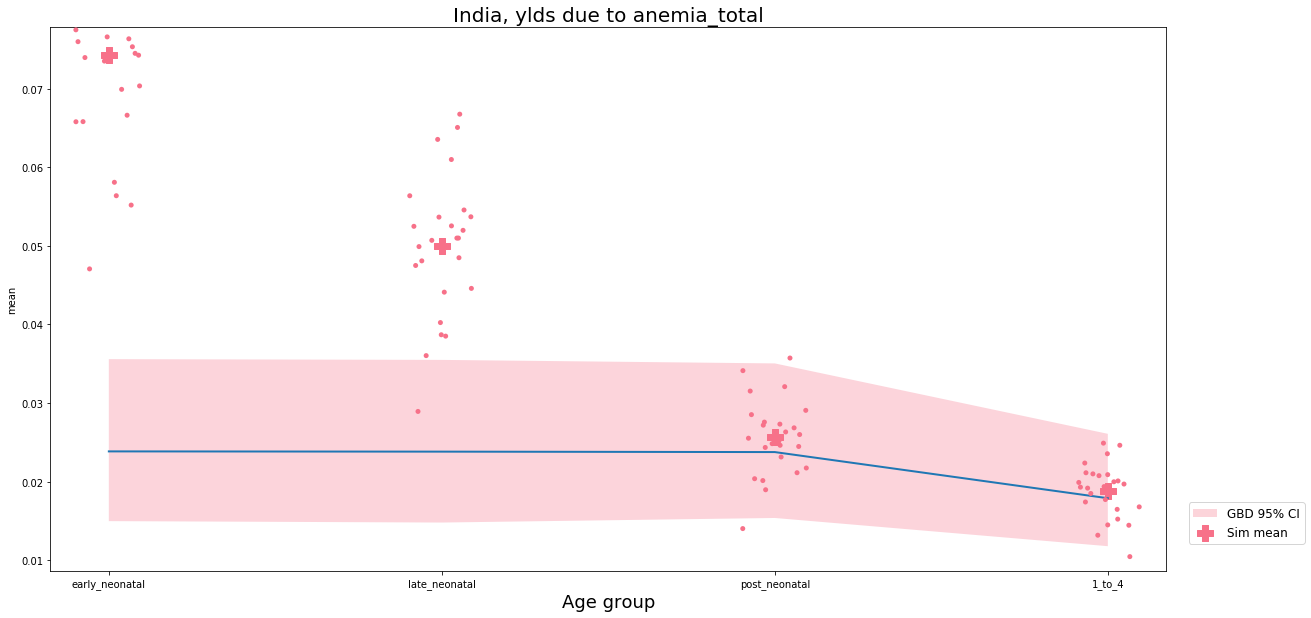

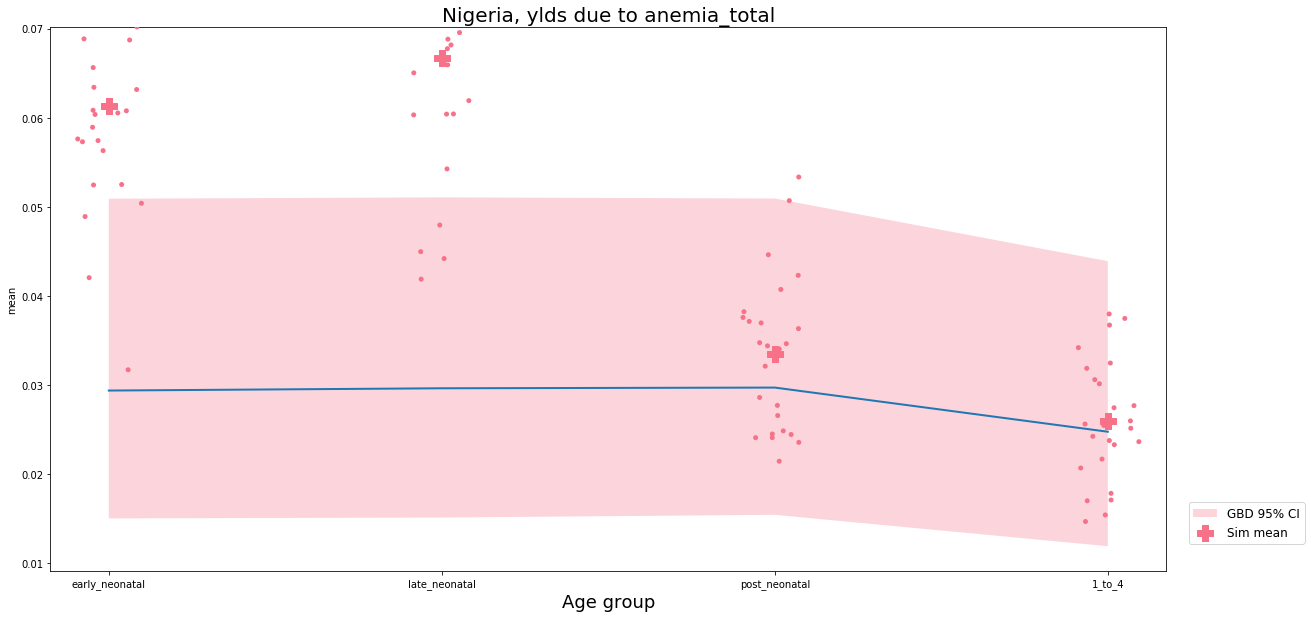

In [13]:
make_multiple_plots(severity_list)

# Conclusions

Early and late neonatal age groups are not validating well, but this is expected and will not influence our model results because the iron fortification intervention does not affect these age groups

We are slightly overestimating anemia prevalence at each severity level, although the overall YLDs due to anemia are within the range of the GBD estimates (although at the high end of the range)